# Numerical integration of the Gaussian plume into pixels

/tmp/ipykernel_4010301/4172240513.py:12: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(2*x*K/U)


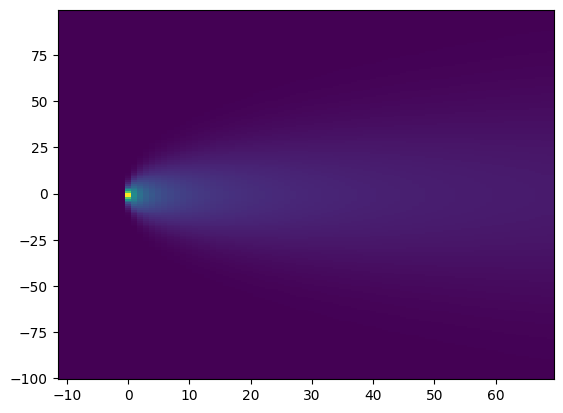

In [1]:
from scipy.integrate import quad, dblquad
from scipy.special import erf
import numpy as np
import matplotlib.pyplot as plt

Q = 3
U = 4
K = 40

# --- Compute Gaussian plume pixels
def f1(x, y0, y1):
    sigma = np.sqrt(2*x*K/U)
    if x<=0:
        return 0
    else:
        return Q/U/2 * (erf(y1/np.sqrt(2)/sigma) -  erf(y0/np.sqrt(2)/sigma))
    
XX = np.arange(-11,70,1)+0.0005 # 0.0005 used in paper...
YY = np.arange(-100,100,1)+0.0005 # 0.0005 used in paper...
results = np.zeros((len(YY),len(XX)))
for i, x in enumerate(XX):
    for j,y in enumerate(YY):
        results[j,i], _ = quad(f1, x, x+1, args=(y,y+1))

#  --- Compute Gaussian plume VZ (or V_y) winds
def f2(x, y0, y1):
    # https://www.wolframalpha.com/input?i=Integrate%5B+Q%2FU%2Fsqrt%282*pi%29+%2F+sqrt%28+2*K*x%2FU+%29+*+exp%28+-y%5E2%2F%282*2*K*x%2FU%29+%29+*+y%2F%282*x%29%2C+y+%5D
    sigma = np.sqrt(2*x*K/U)
    if x<=0:
        return 0
    else:
        return - K*Q/(2*np.pi) / sigma / U**2 * ( np.exp( -y1**2/(2*sigma**2)) - np.exp( -y0**2/(2*sigma**2)) )
        
VZ = np.zeros((len(YY),len(XX)))
res = np.zeros((len(YY),len(XX)))
for i, x in enumerate(XX):
    for j,y in enumerate(YY):
        res[j,i]= quad(f1, x, x+1, args=(y,y+1))[0]
        if res[j,i] != 0:
            VZ[j,i] = quad(f2, x, x+1, args=(y,y+1))[0] / res[j,i]
VZ = np.nan_to_num(VZ)
VZP = np.zeros((len(YY),len(XX)))
res = np.zeros((len(YY),len(XX)))
for i, x in enumerate(XX):
    for j,y in enumerate(YY):
        res[j,i]= quad(f1, x, x+1, args=(y+0.5,y+1.5))[0]
        if res[j,i] != 0:
            VZP[j,i] = quad(f2, x, x+1, args=(y+0.5,y+1.5))[0] / res[j,i]
VZP = np.nan_to_num(VZP)

plt.pcolor( XX, YY, results )

# Figure 4

original version used


/tmp/ipykernel_4010301/2046146530.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im=plt.pcolor(X, Y, results, rasterized=True )


Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]
vx .shape= (200, 81) Vy .shape (200, 81)
ddx.shape= (199, 81) ddy.shape= (200, 80)


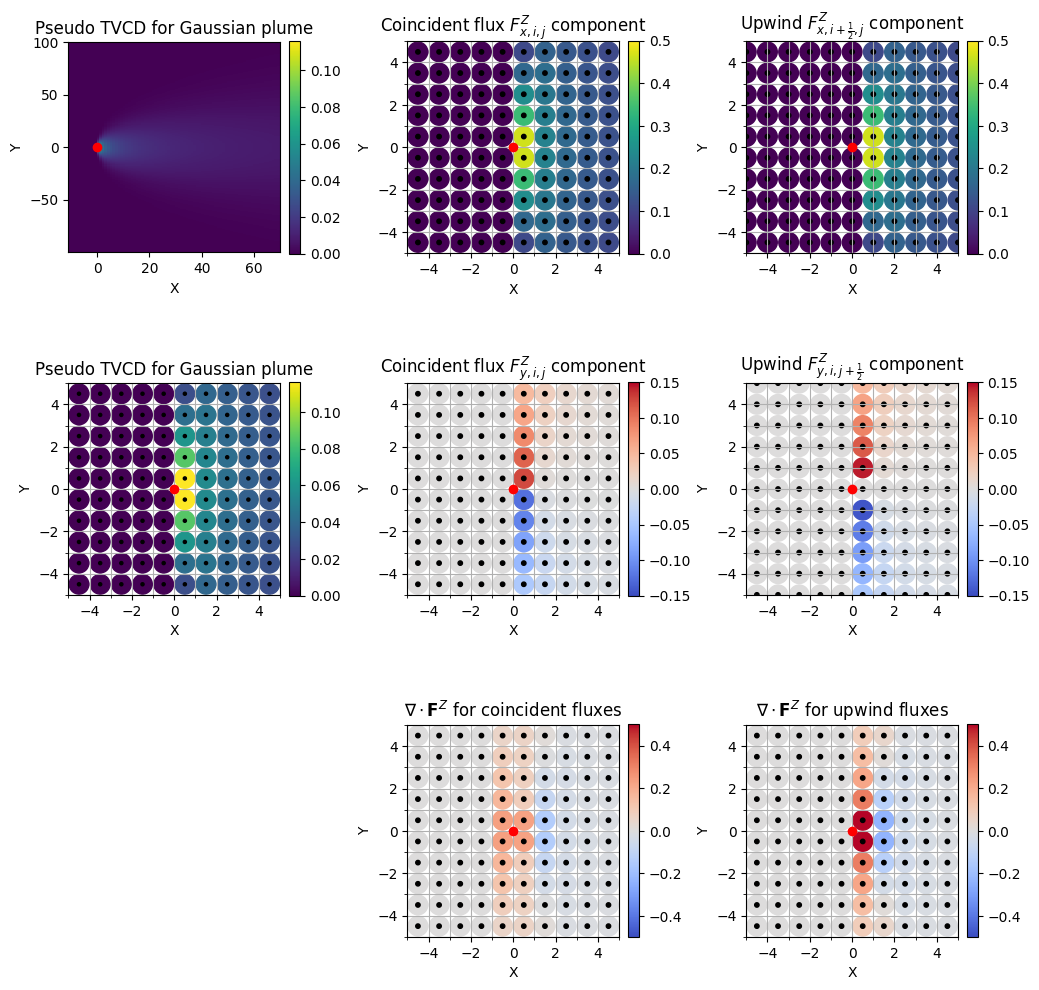

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

negativecolormap = 'coolwarm'

def divergence(Vx, Vy, x, y, method='mine'):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    
    # Original
    if method=='orig':
        print('original version used')
        ddx, _ = np.gradient(Vx, x, y)
        _, ddy = np.gradient(Vy, x, y)

    elif method=='staggered':
        print('Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]')
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        ddx = (Vx[1:,:]-Vx[:-1,:])/(dx[:,np.newaxis])
#         ddx = np.concatenate( (ddx), axis=0)
        ddy = (Vy[:,1:]-Vy[:,:-1])/(dy[np.newaxis,:])
#         ddy = np.concatenate( (ddy), axis=1)
        print("vx .shape=",Vx.shape, "Vy .shape",Vy.shape)
        print("ddx.shape=",ddx.shape,"ddy.shape=",ddy.shape)
        ddx = ddx[:,1:]
        ddy = ddy[1:,:]
    else:
        print('My method used')
        dx = x[2:]-x[:-2]
        dy = y[2:]-y[:-2]
        ddx = (Vx[2:,:]-Vx[:-2,:])/(2*dx[:,np.newaxis])
        ddx = np.concatenate( (ddx, ddx[0:1,:], ddx[0:1,:]), axis=0)
        ddy = (Vy[:,2:]-Vy[:,:-2])/(2*dy[np.newaxis,:])
        ddy = np.concatenate( (ddy[:,0:1], ddy, ddy[:,0:1]), axis=1)
    return ddx + ddy

PIXEL=200

X, Y = np.meshgrid(XX+0.5, YY+0.5) # I integrated from XX[i] to XX[i+1], so X and Y and the mid points by adding halves
Fx = U  * results
Fy = VZ * results
RES = divergence(Fy, Fx, YY+0.5, XX+0.5, method='orig')

plt.figure(figsize=(10.5,10.5))


plt.subplot(3,3,1)
# plt.pcolor(X, Y, results, vmin=0, vmax=0.1)
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
plt.grid()
im=plt.pcolor(X, Y, results, rasterized=True )
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.scatter(X, Y, results*0+5, 'k' )
plt.plot(0, 0, 'ro')
plt.title('Pseudo TVCD for Gaussian plume')
plt.gca().set_aspect(abs((X.min()-X.max())/(Y.min()-Y.max()))*1)
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(3,3,4)
# plt.pcolor(X, Y, results, vmin=0, vmax=0.1)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
im=plt.scatter(X, Y, results*0+PIXEL, results,rasterized=True )
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.colorbar()
plt.scatter(X, Y, results*0+5, 'k' )
plt.plot(0, 0, 'ro')
plt.title('Pseudo TVCD for Gaussian plume')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


# Coincident fluxes
plt.subplot(3,3,2)
# plt.pcolor(X, Y, Fy )
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title(r'Coincident flux $F^Z_{x,i,j}$ component')
im=plt.scatter(X, Y, Fy*0+PIXEL, Fx,rasterized=True, vmin=0, vmax=0.5 )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter(X, Y, Fy*0+10, 'k' )
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,5)
# plt.pcolor(X, Y, Fy )
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title(r'Coincident flux $F^Z_{y,i,j}$ component')
im=plt.scatter(X, Y, Fy*0+PIXEL, Fy,rasterized=True, vmin=-0.15, vmax=0.15, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter(X, Y, Fy*0+10, 'k' )
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,8)
im=plt.scatter( X, Y, RES*0+PIXEL, RES, vmin=-0.5, vmax=0.5,rasterized=True, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X, Y, RES*0+10, 'k' )
plt.title(r'$\nabla \cdot \mathbf{F}^Z$ for coincident fluxes')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


# Upwind fluxes
Fx = U           * results # The upwind 'wind' is constant, U
Fy = np.concatenate( (
     np.where( VZP[:-1,:] > 0, 
               VZP[:-1,:] * results[:-1,:],   # Upwind wind
               VZP[:-1,:] * results[1:,:] ),  # Upwind wind (from a cell later)
               VZP[-1:,:] * results[-1:,:]))  # Repeat the last row...
RES2 = divergence(Fy, Fx, YY+1, XX+1, method='staggered')
plt.subplot(3,3,3)
im=plt.scatter( X+0.5, Y, Fx*0+PIXEL, Fx,rasterized=True, vmin=0, vmax=0.5 )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X+0.5, Y, Fx*0+10, 'k' )
plt.title(r'Upwind $F^Z_{x,i+\frac{1}{2},j}$ component')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,6)
im=plt.scatter( X, Y+0.5, Fx*0+PIXEL, Fy,rasterized=True, vmin=-0.15, vmax=0.15, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X, Y+0.5, Fx*0+10, 'k' )
plt.title(r'Upwind $F^Z_{y,i,j+\frac{1}{2}}$ component')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,9)
im=plt.scatter( X[1:,1:], Y[1:,1:], RES2*0+PIXEL, RES2, vmin=-0.5, vmax=0.5,rasterized=True, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X[1:,1:], Y[1:,1:], RES2*0+10, 'k'  )
plt.title(r'$\nabla \cdot \mathbf{F}^Z$ for upwind fluxes')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)

plt.tight_layout(w_pad = 0.4, h_pad=0.4)
# plt.show()

plt.savefig('upwindfluxes.ps', dpi=300)



In [3]:
print(RES[80:120,8:12].sum(), RES2[80:120,8:12].sum())

2.9993455026124365 2.9991636513658997


# Figure 5

SNR = 0.1


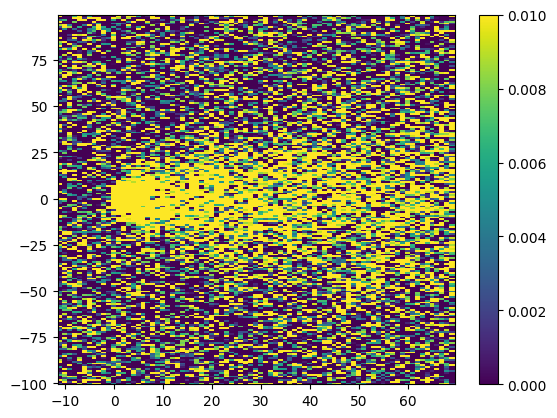

In [4]:
s = results.mean()**2 / 0.1
SNR = results.mean()**2 / s
print("SNR =", SNR)

np.random.seed(43)
noise = np.random.normal(0, np.sqrt(s), [YY.shape[0], XX.shape[0]])

results_noisy = results + noise
plt.pcolor(XX, YY, results_noisy, vmin=0, vmax=0.01)
plt.colorbar()
plt.show()



original version used


/tmp/ipykernel_4010301/3376077775.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im=plt.pcolor(X, Y, results_noisy, rasterized=True )


Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]
vx .shape= (200, 81) Vy .shape (200, 81)
ddx.shape= (199, 81) ddy.shape= (200, 80)
2.619409740664949 2.4296392415950123


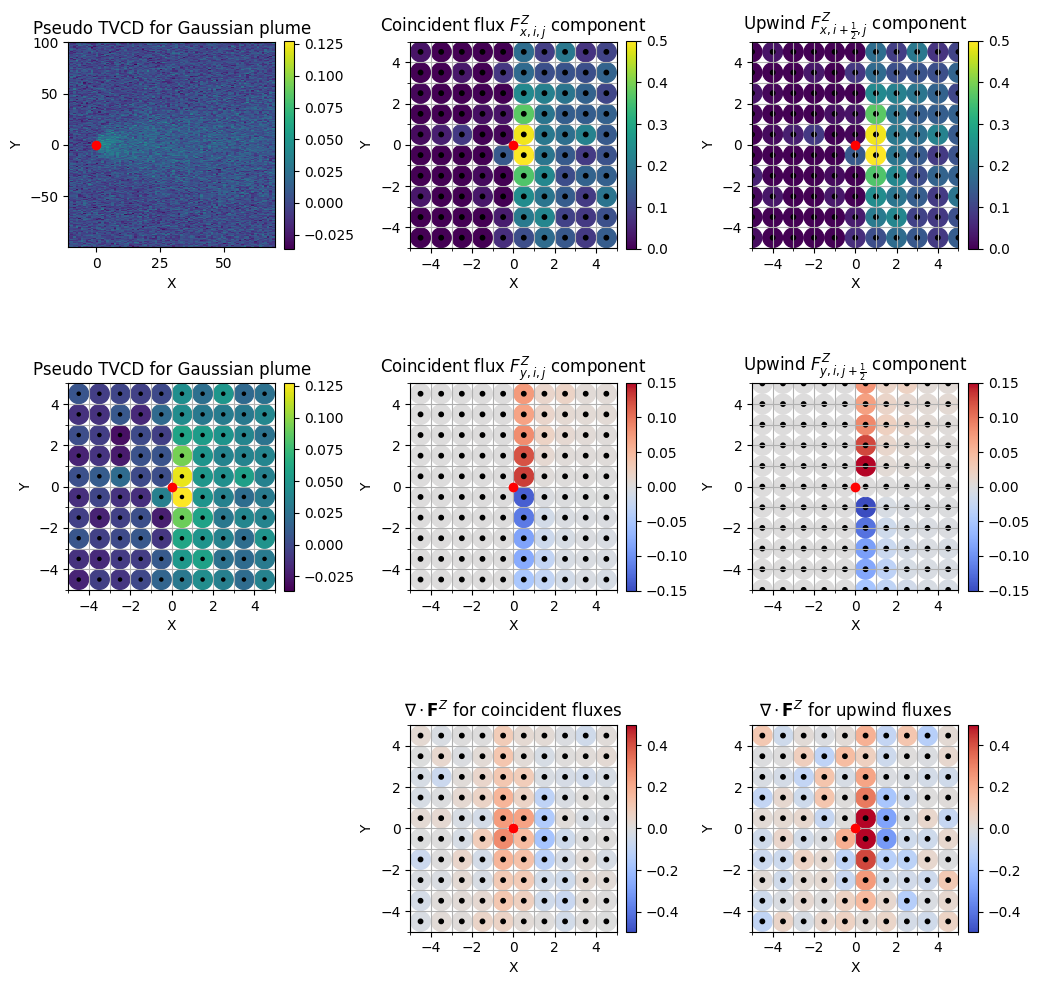

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

negativecolormap = 'coolwarm'

def divergence(Vx, Vy, x, y, method='mine'):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    
    # Original
    if method=='orig':
        print('original version used')
        ddx, _ = np.gradient(Vx, x, y)
        _, ddy = np.gradient(Vy, x, y)

    elif method=='staggered':
        print('Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]')
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        ddx = (Vx[1:,:]-Vx[:-1,:])/(dx[:,np.newaxis])
#         ddx = np.concatenate( (ddx), axis=0)
        ddy = (Vy[:,1:]-Vy[:,:-1])/(dy[np.newaxis,:])
#         ddy = np.concatenate( (ddy), axis=1)
        print("vx .shape=",Vx.shape, "Vy .shape",Vy.shape)
        print("ddx.shape=",ddx.shape,"ddy.shape=",ddy.shape)
        ddx = ddx[:,1:]
        ddy = ddy[1:,:]
    else:
        print('My method used')
        dx = x[2:]-x[:-2]
        dy = y[2:]-y[:-2]
        ddx = (Vx[2:,:]-Vx[:-2,:])/(2*dx[:,np.newaxis])
        ddx = np.concatenate( (ddx, ddx[0:1,:], ddx[0:1,:]), axis=0)
        ddy = (Vy[:,2:]-Vy[:,:-2])/(2*dy[np.newaxis,:])
        ddy = np.concatenate( (ddy[:,0:1], ddy, ddy[:,0:1]), axis=1)
    return ddx + ddy

PIXEL=200

X, Y = np.meshgrid(XX+0.5, YY+0.5) # I integrated from XX[i] to XX[i+1], so X and Y and the mid points by adding halves
Fx = U  * results_noisy
Fy = VZ * results_noisy
RES = divergence(Fy, Fx, YY+0.5, XX+0.5, method='orig')

plt.figure(figsize=(10.5,10.5))


plt.subplot(3,3,1)
# plt.pcolor(X, Y, results_noisy, vmin=0, vmax=0.1)
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
plt.grid()
im=plt.pcolor(X, Y, results_noisy, rasterized=True )
# plt.colorbar()
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.scatter(X, Y, results_noisy*0+5, 'k' )
plt.plot(0, 0, 'ro')
plt.title('Pseudo TVCD for Gaussian plume')
plt.gca().set_aspect(abs((X.min()-X.max())/(Y.min()-Y.max()))*1)
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(3,3,4)
# plt.pcolor(X, Y, results_noisy, vmin=0, vmax=0.1)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
im=plt.scatter(X, Y, results_noisy*0+PIXEL, results_noisy,rasterized=True )
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.colorbar()
plt.scatter(X, Y, results_noisy*0+5, 'k' )
plt.plot(0, 0, 'ro')
plt.title('Pseudo TVCD for Gaussian plume')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


# Coincident fluxes
plt.subplot(3,3,2)
# plt.pcolor(X, Y, Fy )
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title(r'Coincident flux $F^Z_{x,i,j}$ component')
im=plt.scatter(X, Y, Fy*0+PIXEL, Fx,rasterized=True, vmin=0, vmax=0.5 )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter(X, Y, Fy*0+10, 'k' )
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,5)
# plt.pcolor(X, Y, Fy )
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title(r'Coincident flux $F^Z_{y,i,j}$ component')
im=plt.scatter(X, Y, Fy*0+PIXEL, Fy,rasterized=True, vmin=-0.15, vmax=0.15, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter(X, Y, Fy*0+10, 'k' )
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,8)
im=plt.scatter( X, Y, RES*0+PIXEL, RES, vmin=-0.5, vmax=0.5,rasterized=True, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X, Y, RES*0+10, 'k' )
plt.title(r'$\nabla \cdot \mathbf{F}^Z$ for coincident fluxes')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


# Upwind fluxes
Fx = U           * results_noisy # The upwind 'wind' is constant, U
Fy = np.concatenate( (
     np.where( VZP[:-1,:] > 0, 
               VZP[:-1,:] * results_noisy[:-1,:],   # Upwind wind
               VZP[:-1,:] * results_noisy[1:,:] ),  # Upwind wind (from a cell later)
               VZP[-1:,:] * results_noisy[-1:,:]))  # Repeat the last row...
RES2 = divergence(Fy, Fx, YY+1, XX+1, method='staggered')
plt.subplot(3,3,3)
im=plt.scatter( X+0.5, Y, Fx*0+PIXEL, Fx,rasterized=True, vmin=0, vmax=0.5 )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X+0.5, Y, Fx*0+10, 'k' )
plt.title(r'Upwind $F^Z_{x,i+\frac{1}{2},j}$ component')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,6)
im=plt.scatter( X, Y+0.5, Fx*0+PIXEL, Fy,rasterized=True, vmin=-0.15, vmax=0.15, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X, Y+0.5, Fx*0+10, 'k' )
plt.title(r'Upwind $F^Z_{y,i,j+\frac{1}{2}}$ component')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)


plt.subplot(3,3,9)
im=plt.scatter( X[1:,1:], Y[1:,1:], RES2*0+PIXEL, RES2, vmin=-0.5, vmax=0.5,rasterized=True, cmap=negativecolormap )
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.scatter( X[1:,1:], Y[1:,1:], RES2*0+10, 'k'  )
plt.title(r'$\nabla \cdot \mathbf{F}^Z$ for upwind fluxes')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.plot(0, 0, 'ro')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(which='both')
plt.xticks(np.arange(-4,6,2))
ax = plt.gca()
ax.set_xticks(np.arange(-5,6), minor=True)
ax.set_yticks(np.arange(-5,6), minor=True)

plt.tight_layout(w_pad = 0.4, h_pad=0.4)
# plt.show()

plt.savefig('upwindfluxes.ps', dpi=300)

print(RES[80:120,8:25].sum(), RES2[80:120,8:25].sum())



# Figure 6

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm

def divergence(Vx, Vy, x, y, method='mine'):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    
    # Original
    if method=='orig':
#         print('original version used')
        ddx, _ = np.gradient(Vx, x, y)
        _, ddy = np.gradient(Vy, x, y)

    elif method=='staggered':
#         print('Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]')
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        ddx = (Vx[1:,:]-Vx[:-1,:])/(dx[:,np.newaxis])
#         ddx = np.concatenate( (ddx), axis=0)
        ddy = (Vy[:,1:]-Vy[:,:-1])/(dy[np.newaxis,:])
#         ddy = np.concatenate( (ddy), axis=1)
#         print("vx .shape=",Vx.shape, "Vy .shape",Vy.shape)
#         print("ddx.shape=",ddx.shape,"ddy.shape=",ddy.shape)
        ddx = ddx[:,1:]
        ddy = ddy[1:,:]
    else:
        print('My method used')
        dx = x[2:]-x[:-2]
        dy = y[2:]-y[:-2]
        ddx = (Vx[2:,:]-Vx[:-2,:])/(2*dx[:,np.newaxis])
        ddx = np.concatenate( (ddx, ddx[0:1,:], ddx[0:1,:]), axis=0)
        ddy = (Vy[:,2:]-Vy[:,:-2])/(2*dy[np.newaxis,:])
        ddy = np.concatenate( (ddy[:,0:1], ddy, ddy[:,0:1]), axis=1)
    return ddx + ddy

est_c_full = []
est_c_lim = []
est_u_full = []
est_u_lim = []
est_2_lim = []

s = results.mean()**2 / 0.1
SNR = results.mean()**2 / s
print("SNR =", SNR)

for i in tqdm(range(1000000)):    
    noise = np.random.normal(0, np.sqrt(s), [YY.shape[0], XX.shape[0]]) 
    results_noisy = results + noise
#     results_noisy = noise # Just fit noise..

    X, Y = np.meshgrid(XX+0.5, YY+0.5) # I integrated from XX[i] to XX[i+1], so X and Y and the mid points by adding halves
    Fx = U  * results_noisy
    Fy = VZ * results_noisy
    RES = divergence(Fy, Fx, YY+0.5, XX+0.5, method='orig')


    # Upwind fluxes
    Fx = U           * results_noisy # The upwind 'wind' is constant, U
    Fy = np.concatenate( (
         np.where( VZP[:-1,:] > 0, 
                   VZP[:-1,:] * results_noisy[:-1,:],   # Upwind wind
                   VZP[:-1,:] * results_noisy[1:,:] ),  # Upwind wind (from a cell later)
                   VZP[-1:,:] * results_noisy[-1:,:]))  # Repeat the last row...
    RES2 = divergence(Fy, Fx, YY+1, XX+1, method='staggered')
    
    COMB =  (RES[1:,1:] + RES2)/2
    
    est_c_full.append( RES.sum() )
    est_u_full.append( RES2.sum() )
    est_c_lim.append( RES[80:120,8:12].sum() )
    est_u_lim.append(RES2[80:120,8:12].sum() )
    est_2_lim.append(COMB[80:120,8:12].sum() )
    
    
    
print( np.asarray(est_c_full).mean(),
       np.asarray(est_u_full).mean(),
       np.asarray(est_c_lim).mean(),
       np.asarray(est_u_lim).mean(),
       np.asarray(est_2_lim).mean() )

SNR = 0.1


100%|██████████| 1000000/1000000 [29:29<00:00, 565.28it/s]


2.9774680349449443 2.9788422091845366 2.999164291835932 2.9988346375478745 2.995155782882154


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


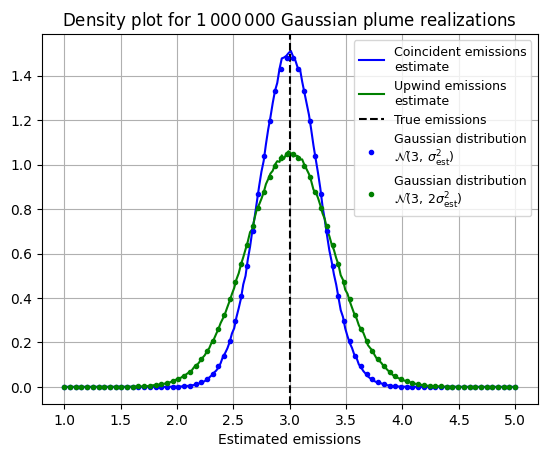

In [7]:
from scipy.stats import gaussian_kde
import scipy.stats as stats
# --- Print coincident estimate
data = np.asarray(est_c_lim)
density = gaussian_kde(data)
xs = np.linspace(1,5,200)
density.covariance_factor = lambda : .01
density._compute_covariance()
plt.plot(xs,density(xs), 'b', label='Coincident emissions\nestimate')

# --- Print upwind estimate
data = np.asarray(est_u_lim)
density = gaussian_kde(data)
density.covariance_factor = lambda : .01
density._compute_covariance()
plt.plot(xs,density(xs), 'g', label='Upwind emissions\nestimate')

# --- Print combined estimate
# data = np.asarray(est_2_lim)
# density = gaussian_kde(data)
# density.covariance_factor = lambda : .1
# density._compute_covariance()
# plt.plot(xs,density(xs), label='Combined emissions estimate')

xmin, xmax, ymin, ymax = plt.axis()
plt.plot([3, 3], [ymin, ymax], 'k--', label='True emissions')

mu = 3
variance = 0.072 # Fx only
sigma = np.sqrt(variance)
x = np.linspace(xs[0],xs[-1], 80)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'b.', label='Gaussian distribution\n$\mathcal{N}(3,\,\sigma_\mathrm{est}^2)$')
plt.plot(x, stats.norm.pdf(x, mu, np.sqrt(2)*sigma), 'g.', label='Gaussian distribution\n$\mathcal{N}(3,\,2\sigma_\mathrm{est}^2)$')
# plt.plot(x, stats.norm.pdf(x, mu, 1.22*sigma), '.', label=r'Gaussian distribution $\mathcal{N}(3,1.5\sigma^2)$')
plt.legend(loc='upper right', prop={'size': 9})
plt.title(r'Density plot for 1$\,$000$\,$000 Gaussian plume realizations')
plt.grid()
plt.xlabel('Estimated emissions')
plt.ylim([ymin, ymax])
plt.savefig('densityplot.pdf', dpi=300)
plt.savefig('densityplot.ps', dpi=300)


plt.show()



# Figure 7

/tmp/ipykernel_4010301/1862277364.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(2*x*K/U)


original version used
original version used
original version used
original version used
original version used
original version used
original version used
original version used
original version used
original version used
Line integral of the line integral :  -3.000049360445374
Line integral of the p.l. integral :  -2.9999610638707166


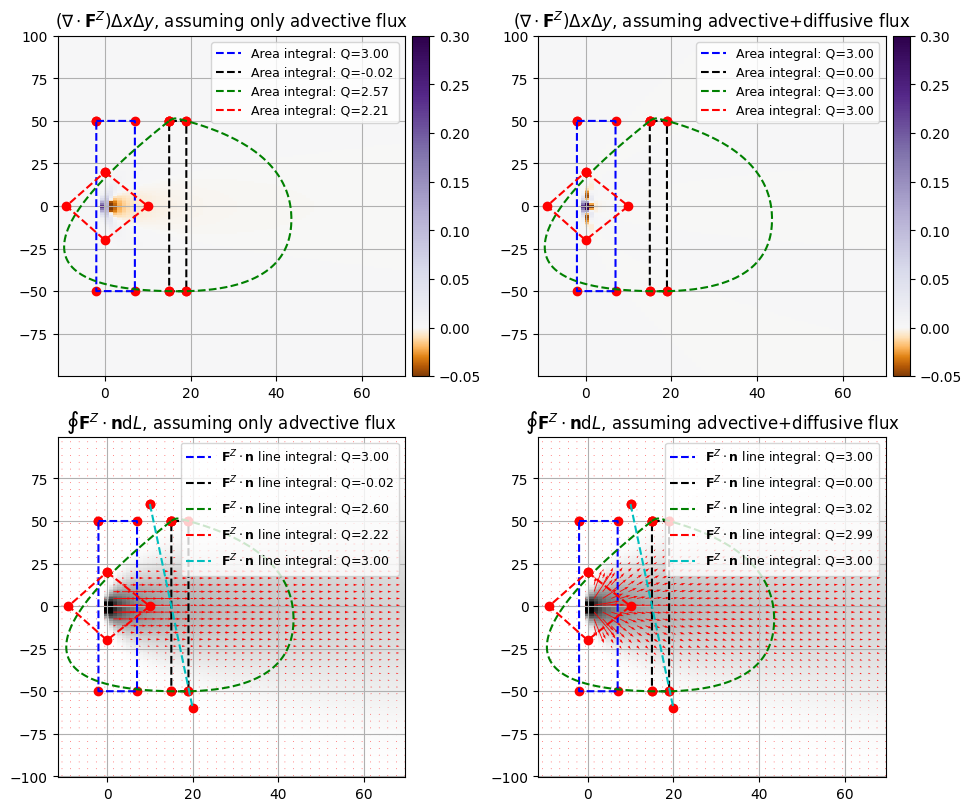

In [8]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d # Different interface to the same function
from scipy.interpolate import splprep, splev, interp2d, NearestNDInterpolator, LinearNDInterpolator
from matplotlib.path import Path
from collections import Counter
from matplotlib.colors import TwoSlopeNorm
from scipy.integrate import quad, dblquad
from scipy.special import erf
import numpy as np

Q = 3
U = 4
K = 40

def f1(x, y0, y1):
    sigma = np.sqrt(2*x*K/U)
    if x<=0:
        return 0
    else:
        return Q/U/2 * (erf(y1/np.sqrt(2)/sigma) -  erf(y0/np.sqrt(2)/sigma))
    
XX = np.arange(-11,70,1)+0.0005 # 0.0005 used in paper...
YY = np.arange(-100,100,1)+0.0005 # 0.0005 used in paper...
results = np.zeros((len(YY),len(XX)))
for i, x in enumerate(XX):
    for j,y in enumerate(YY):
        results[j,i], _ = quad(f1, x, x+1, args=(y,y+1))

fig, ax = plt.subplots(2, 2, figsize=(12*0.8,10*0.8), constrained_layout=True)

X, Y = np.meshgrid(XX+0.5, YY+0.5) # I integrated from XX[i] to XX[i+1], so X and Y and the mid points.

# Centered fluxes
Fx = U  * results
Fy = U *(Y/(2*X)) * results


def divergence(Vx, Vy, x, y, method='mine'):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    
    # Original
    if method=='orig':
        print('original version used')
        ddx, _ = np.gradient(Vx, x, y)
        _, ddy = np.gradient(Vy, x, y)

    elif method=='staggered':
        print('Staggered version used [assuming Vx[i,j] is @ ((i+1/2) dx, j dy) and Vy @ (i dx, (j+1/2) dy), throwing away the first row & column because they dont overlap in FD space]')
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        ddx = (Vx[1:,:]-Vx[:-1,:])/(dx[:,np.newaxis])
#         ddx = np.concatenate( (ddx), axis=0)
        ddy = (Vy[:,1:]-Vy[:,:-1])/(dy[np.newaxis,:])
#         ddy = np.concatenate( (ddy), axis=1)
        print("vx .shape=",Vx.shape, "Vy .shape",Vy.shape)
        print("ddx.shape=",ddx.shape,"ddy.shape=",ddy.shape)
        ddx = ddx[:,1:]
        ddy = ddy[1:,:]
    else:
        print('My method used')
        dx = x[2:]-x[:-2]
        dy = y[2:]-y[:-2]
        ddx = (Vx[2:,:]-Vx[:-2,:])/(2*dx[:,np.newaxis])
        ddx = np.concatenate( (ddx, ddx[0:1,:], ddx[0:1,:]), axis=0)
        ddy = (Vy[:,2:]-Vy[:,:-2])/(2*dy[np.newaxis,:])
        ddy = np.concatenate( (ddy[:,0:1], ddy, ddy[:,0:1]), axis=1)
    return ddx + ddy


def return_closed_curve(pts, k=1, npts=1000):
    '''
    Compute x and y coordinates for a closed curve, given points in pts
    k=1 gives a linear interpolation, k=3 a cubic spline (=smoother).
    pts_i = x_i, y_i; i.e., pts=2xN array of 2D points.
    The output is regularly spaced in Euclidean space (i.e. dx^2+dy^2 is constant).
    Based on https://stackoverflow.com/a/31466013/4591046
    '''
    tck, u = splprep(pts.T, u=None, s=0.0, per=1, k=k)
    u_new = np.linspace(u.min(), u.max(), npts)
    x, y = splev(u_new, tck, der=0)
    return x, y


def create_mask(X, Y, x, y):
    '''
    Create a matrix mask based on a polygon mask defined on an unstructured grid
    based, but modified to allow unstructured grids, on
    https://stackoverflow.com/a/51208705/4591046
    '''
    width, height=X.shape
    polygon = list(zip(x, y))
    poly_path=Path(polygon)
    coors=np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
    mask = poly_path.contains_points(coors).reshape(width, height)
    return mask

def half_mask_at_edges(mask, axis=0):
    '''
    This function takes a mask, e.g., for axis=1 (horizontal)
    mask = [[0  0  0  0  0],
            [0  1  1  1  0],
            [0  1  1  0  0],
            [0  0  1  0  0],
            [0  0  0  0  0]]
    and converts it to
    mask0= [[0  0  0  0  0],
            [0 .5  1 .5  0],
            [0 .5  .5 0  0],
            [0  0  1  0  0], <- note this special case!
            [0  0  0  0  0]]
    which is a required pre-conditioning step before supplying the masked data to
    a trapz integration, because the integration boundaries should only account 
    for '1/2' the amount of their dx/dy values.
    '''
    mask0 = mask.astype(float)      # Deal with the mask in floating point fashion

    x0 = np.arange(mask0.shape[0])  # Create array with x indices
    y0 = np.arange(mask0.shape[1])  # Create array with y indices

    if axis==0:
        locsX = x0[:-1, np.newaxis]+1/2 + np.diff(mask0*1, axis=0)/2
        difX = np.where(locsX*10%10==0, locsX.astype(int), 0)
        XX = [loc for loc in difX.flatten() if loc!=0]
        XY = np.nonzero(difX)[1]
        # Deduplicate items
        Xcoords = list(zip(XX, XY))
        nits = Counter(Xcoords)
        Xcoords = [k for k, v in nits.items() if v == 1]
        try:
            XX, XY = list(zip(*Xcoords))
        except:
            XX = XY = []
        mask0[(XX), (XY)] = 0.5
    elif axis==1:
        locsY = y0[np.newaxis, :-1]+1/2 + np.diff(mask0*1, axis=1)/2
        difY = np.where(locsY*10%10==0, locsY.astype(int), 0)
        YY = [loc for loc in difY.flatten() if loc!=0]
        YX = np.nonzero(difY)[0]
        Ycoords = list(zip(YX, YY))
        nits = Counter(Ycoords)
        Ycoords = [k for k, v in nits.items() if v == 1]
        try:
            YX, YY = list(zip(*Ycoords))
        except:
            YX = YY = []
        mask0[(YX), (YY)] = 0.5
        
    return mask0

def div_method(Fx, Fy, X, Y):
    '''
    Return divergence field. Fx, Fy, X, Y are N*M grids. Dim. x is size N, y is size M.
    '''
    div = np.zeros_like(Fx)
    divdxdy = np.zeros_like(Fx)
    dx = (X[:,2:]-X[:,:-2])
    dy = (Y[2:,:]-Y[:-2,:])
    dFx = (Fx[:,2:] - Fx[:,:-2])/(dx)
    dFy = (Fy[2:,:] - Fy[:-2,:])/(dy)
    div[1:-1,1:-1] = dFx[1:-1, :] + dFy[:,1:-1]
    divdxdy[1:-1,1:-1] = (dFx[1:-1, :] + dFy[:,1:-1])*dx[1:-1,:]*dy[:,1:-1]/4
    return div, divdxdy


div0dxdy = divergence(Fy*0, Fx, YY+0.5, XX+0.5, method='orig')
div1dxdy = divergence(Fy, Fx, YY+0.5, XX+0.5, method='orig')


# div0, div0dxdy = div_method(Fx, Fy*0, X[:,:], Y[:,:])
# div1, div1dxdy = div_method(Fx, Fy, X, Y)

pts=np.asarray([
    [-2,50],
    [7, 50],
    [7, -50],
    [-2, -50],
    [-2, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy*0, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )

# ax0 = fig.add_subplot(gs[0,0])
d0 = ax[0,0].pcolor(X, Y, div0dxdy, norm = TwoSlopeNorm(vmin=-0.05, vcenter=0, vmax=0.3), cmap='PuOr', rasterized=True )
ax[0,0].grid()
ax[0,0].plot(pts[:,0], pts[:,1], 'ro')
ax[0,0].plot(x_line, y_line, 'b--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))



pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy*0, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,0].plot(pts[:,0], pts[:,1], 'ro')
ax[0,0].plot(x_line, y_line, 'k--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))

pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=2)


DIV = divergence(Fy*0, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,0].plot(pts[:,0], pts[:,1], 'ro')
ax[0,0].plot(x_line, y_line, 'g--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))
pts=np.asarray([
    [0,20],
    [10, 0],
    [0, -20],
    [-9, 0],
    [0,20]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy*0, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,0].plot(pts[:,0], pts[:,1], 'ro')
ax[0,0].plot(x_line, y_line, 'r--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))


ax[0,0].legend(prop={'size': 9})
cb = fig.colorbar(d0, ax=ax[0, 0], pad=0.02)
cb.ax.set_yscale('linear')
ax[0,0].set_title(r'$(\nabla\cdot \mathbf{F}^Z)\Delta x \Delta y$, assuming only advective flux')



pts=np.asarray([
    [-2,50],
    [7, 50],
    [7, -50],
    [-2, -50],
    [-2, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
d1 = ax[0,1].pcolor(X, Y, div1dxdy, norm = TwoSlopeNorm(vmin=-0.05, vcenter=0, vmax=0.3), cmap='PuOr', rasterized=True )
ax[0,1].grid()
ax[0,1].plot(pts[:,0], pts[:,1], 'ro')
ax[0,1].plot(x_line, y_line, 'b--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,1].plot(pts[:,0], pts[:,1], 'ro')
ax[0,1].plot(x_line, y_line, 'k--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=2)
DIV = divergence(Fy, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,1].plot(pts[:,0], pts[:,1], 'ro')
ax[0,1].plot(x_line, y_line, 'g--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))
pts=np.asarray([
    [0,20],
    [10, 0],
    [0, -20],
    [-9, 0],
    [0,20]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
DIV = divergence(Fy, Fx, YY+0.5, XX+0.5, 'orig')
# Apply factor 1/2 at edges of the mask (in y direction)
mask = create_mask(X, Y, x_line, y_line)
mask_ax1 = half_mask_at_edges(mask, axis=1)
DIV_int = np.trapz( DIV*mask_ax1 , dx=YY[1]-YY[0], axis=1)
# Apply factor 1/2 at edges of the mask (in x direction)
mask_sum = mask.sum(axis=1)!=0
mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
DIV_int = np.trapz( DIV_int*mask_ax0 , dx=XX[1]-XX[0]        )
ax[0,1].plot(pts[:,0], pts[:,1], 'ro')
ax[0,1].plot(x_line, y_line, 'r--', label=r'Area integral: Q={:3.2f}'.format(DIV_int))

ax[0,1].legend(prop={'size': 9})
cb = fig.colorbar(d1, ax=ax[0,1], pad=0.02)
# cb = plt.colorbar(d1, ax=ax1)
cb.ax.set_yscale('linear')
ax[0,1].set_title(r'$(\nabla\cdot \mathbf{F}^Z)\Delta x \Delta y$, assuming advective+diffusive flux')

# ##########################################################



def NNintp(Xgrid, Ygrid, Zgrid, xpts, ypts, method='NN'):
    '''
    Do a nearest neighbour interpolation of Z(X,Y) on an, in principle, unstructured grid.
    Xgrid_{i,j} = Xgrid(i,j), 2D array of X coordinates
    Ygrid_{i,j} = Ygrid(i,j), 2D array of Y coordinates
    Zgrid_{i,j} = Z(Xgrid_{i,j}, Ygrid_{i,j}), array of ordinates
    xpts_i = array of x coordinates interpolated to
    ypts_i = array of y coordinates interpolated to
    '''
    if method == 'NN':
        Z_itp = NearestNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    elif method == 'linear':
        Z_itp = LinearNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    else:
        print('Unknown method, should be "NN" or "linear"')
        return 0
    return np.squeeze([Z_itp(x, y) for x, y in zip(xpts, ypts)])


def line_integral(Vx, Vy, x, y):
    '''
    Compute the line integral of a 2D vector-valued function [Vx, Vy].T
    multiplied with an outward pointing normal 'n', on a Cartesian grid.
    \oint V . n dS = \oint (Vx*dy - Vy*dx)
    
    Vx_i = Vx(x_i,y_i)
    Vy_i = Vy(x_i,y_i)
    x_i = array of x_coordinates
    y_i = array of y_coordinates    
    '''
    dx_f = np.diff(x)
    dy_f = np.diff(y)
    Vx_avg = (Vx[1:] + Vx[:-1])/2
    Vy_avg = (Vy[1:] + Vy[:-1])/2
    return (Vx_avg * dy_f - Vy_avg * dx_f).sum()


pts=np.asarray([
    [-2,50],
    [7, 50],
    [7, -50],
    [-2, -50],
    [-2, 50]
])

x_line, y_line = return_closed_curve(pts, npts=1000, k=1)


############################################## STEP 4: NUMERICALLY COMPUTE THE LINE INTEGRAL \oint V\cdot n dA
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
print("Line integral of the line integral : ", LIN_int_full)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy*0, x_line, y_line, method='linear')
LIN_int_part = line_integral(Vx_itp, Vy_itp, x_line, y_line)
print("Line integral of the p.l. integral : ", LIN_int_part)


# Plot the intermediate results -- starts to be memory intensive for large x/y arrays!
# plt.subplot(2,2,3)
ax[1,0].pcolor(XX, YY, results, vmin=0, vmax=0.05, cmap='binary', rasterized=True)
ax[1,0].quiver(X[::4,::2], Y[::4,::2], Fx[::4,::2], Fy[::4,::2]*0, color='r', scale=3)
ax[1,0].grid()
ax[1,0].plot(pts[:,0], pts[:,1], 'ro')
ax[1,0].plot(x_line, y_line, 'b--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_part))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy*0, x_line, y_line, method='linear')
LIN_int_part = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,0].plot(pts[:,0], pts[:,1], 'ro')
ax[1,0].plot(x_line, y_line, 'k--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_part))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=2)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy*0, x_line, y_line, method='linear')
LIN_int_part = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,0].plot(pts[:,0], pts[:,1], 'ro')
ax[1,0].plot(x_line, y_line, 'g--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_part))
pts=np.asarray([
    [0,20],
    [10, 0],
    [0, -20],
    [-9, 0],
    [0,20]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy*0, x_line, y_line, method='linear')
LIN_int_part = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,0].plot(pts[:,0], pts[:,1], 'ro')
ax[1,0].plot(x_line, y_line, 'r--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_part))
pts=np.asarray([
    [10,60],
    [20, -60],
    [10,60]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
x_line, y_line = x_line[:len(x_line)//2], y_line[:len(y_line)//2]
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy*0, x_line, y_line, method='linear')
LIN_int_part = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,0].plot(pts[:,0], pts[:,1], 'ro')
ax[1,0].plot(x_line, y_line, 'c--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_part))

ax[1,0].legend(prop={'size': 9})
# plt.colorbar()
ax[1,0].set_title(r'$\oint \mathbf{F}^Z\cdot \mathbf{n}\mathrm{d}L$, assuming only advective flux')
# cb = plt.colorbar()
# cb.remove() 




# plt.subplot(2,2,4)
ax[1,1].pcolor(XX, YY, results, vmin=0, vmax=0.05, cmap='binary', rasterized=True)
ax[1,1].quiver(X[::4,::2], Y[::4,::2], Fx[::4,::2], Fy[::4,::2], color='r', scale=3)
ax[1,1].grid()
pts=np.asarray([
    [-2,50],
    [7, 50],
    [7, -50],
    [-2, -50],
    [-2, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,1].plot(pts[:,0], pts[:,1], 'ro')
ax[1,1].plot(x_line, y_line, 'b--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_full))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,1].plot(pts[:,0], pts[:,1], 'ro')
ax[1,1].plot(x_line, y_line, 'k--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_full))
pts=np.asarray([
    [15,50],
    [19, 50],
    [19, -50],
    [15, -50],
    [15, 50]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=2)
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,1].plot(pts[:,0], pts[:,1], 'ro')
ax[1,1].plot(x_line, y_line, 'g--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_full))
pts=np.asarray([
    [0,20],
    [10, 0],
    [0, -20],
    [-9, 0],
    [0,20]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
# x_line, y_line = x_line[:len(x_line)//2], y_line[:len(y_line)//2]
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,1].plot(pts[:,0], pts[:,1], 'ro')
ax[1,1].plot(x_line, y_line, 'r--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_full))
pts=np.asarray([
    [10,60],
    [20, -60],
    [10,60]
])
x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
x_line, y_line = x_line[:len(x_line)//2], y_line[:len(y_line)//2]
Vx_itp = NNintp(X+0.5, Y, Fx, x_line, y_line, method='linear')
Vy_itp = NNintp(X, Y+0.5, Fy, x_line, y_line, method='linear')
LIN_int_full = line_integral(Vx_itp, Vy_itp, x_line, y_line)
ax[1,1].plot(pts[:,0], pts[:,1], 'ro')
ax[1,1].plot(x_line, y_line, 'c--', label=r'$\mathbf{{F}}^Z\cdot \mathbf{{n}}$ line integral: Q={:3.2f}'.format(-LIN_int_full))

ax[1,1].legend(prop={'size': 9})
# plt.colorbar()
ax[1,1].set_title(r'$\oint \mathbf{F}^Z\cdot \mathbf{n}\mathrm{d}L$, assuming advective+diffusive flux')

plt.savefig('GP.pdf', dpi=300)
# plt.savefig('GP.ps', dpi=300)



# plt.subplots_adjust(hspace=0.2, wspace=0.05)
# ax[1, 0].get_shared_x_axes().join(ax[0, 0], ax[1, 0])  # Align bottom subplots

